# Full-waveform inversion using psvWave

_Copyright Lars Gebraad, 2022_ https://github.com/larsgeb/psvWave

In this notebook it is shown how the `psvWave` package is used to perform FWI on synthetic targets. Note that this notebook (and psvWave in general) uses moment tensor sources, instead of volume/force injections.

In [1]:
import psvWave
import numpy
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter


font = {"size": 20}
matplotlib.rc("font", **font)


model = psvWave.fdModel("default_testing_configuration.ini")

Loading configuration file: 'default_testing_configuration.ini'.
Parsing passed configuration.


We will try to retrieve discrete shapes in a synthetic model. To that extent, let's first create the targets.

In [2]:
background_values = numpy.array([2000, 800, 1500])

# Create target model ---------------------------------------------------------

# Get the coordinates of every grid point
IX, IZ = model.get_coordinates(True)
extent = model.get_extent(True)
# Get the associated parameter fields
vp, vs, rho = model.get_parameter_fields()

vp[:] = background_values[0]
vs[:] = background_values[1]
rho[:] = background_values[2]

field_shape = vp.shape

vp_starting = numpy.ones(field_shape) * background_values[0]
vs_starting = numpy.ones(field_shape) * background_values[1]
rho_starting = numpy.ones(field_shape) * background_values[2]

x_middle = (IX.max() + IX.min()) / 2
z_middle = (IZ.max() + IZ.min()) / 2

circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < 15
vs = vs_starting * (1 - 0.1 * circle)
vp = vp_starting * (1 - 0.1 * circle)


x_middle = (IX.max() + IX.min()) / 6
z_middle = (IZ.max() + IZ.min()) / 2

circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < 15
vs = vs * (1 + 0.1 * circle)
rho = rho * (1 + 0.1 * circle)

x_middle = (IX.max() + IX.min()) * 5 / 6
z_middle = (IZ.max() + IZ.min()) / 2

circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < 15
vp = vp * (1 + 0.1 * circle)
rho = rho * (1 + 0.1 * circle)

vp_target = vp.copy()
vs_target = vs.copy()
rho_target = rho.copy()


model.set_parameter_fields(vp_target, vs_target, rho_target)

Let's have a look at the funky stuff we just made.

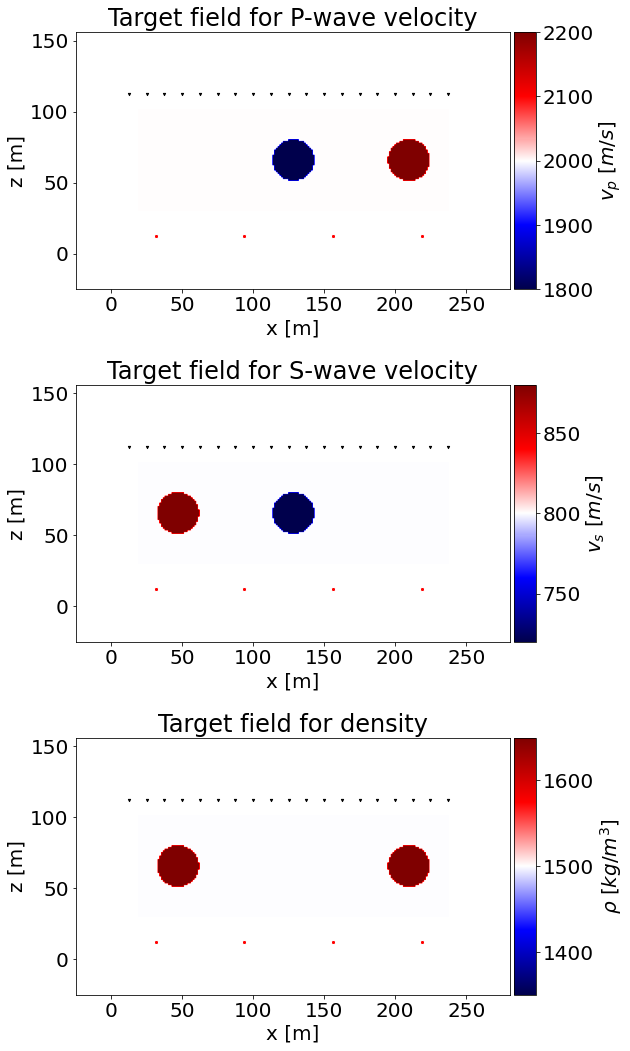

In [3]:
plt.figure(figsize=(9, 15))
plt.tight_layout()
axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

parameters = ["P-wave velocity", "S-wave velocity", "density"]
[
    axis.set_title(f"Target field for {parameter}")
    for axis, parameter in zip(axes, parameters)
]

_ = model.plot_model_vector(
    model.get_model_vector(),
    axes=axes,
    vmin=background_values * 0.9,
    vmax=background_values * 1.1,
)

That looks interesting. It might give us some insight into cross-talk between parameters.

Let us simulate the 'fake' data, and plot it. We will directly set this fake data, generated with the true model, as our 'observations'.

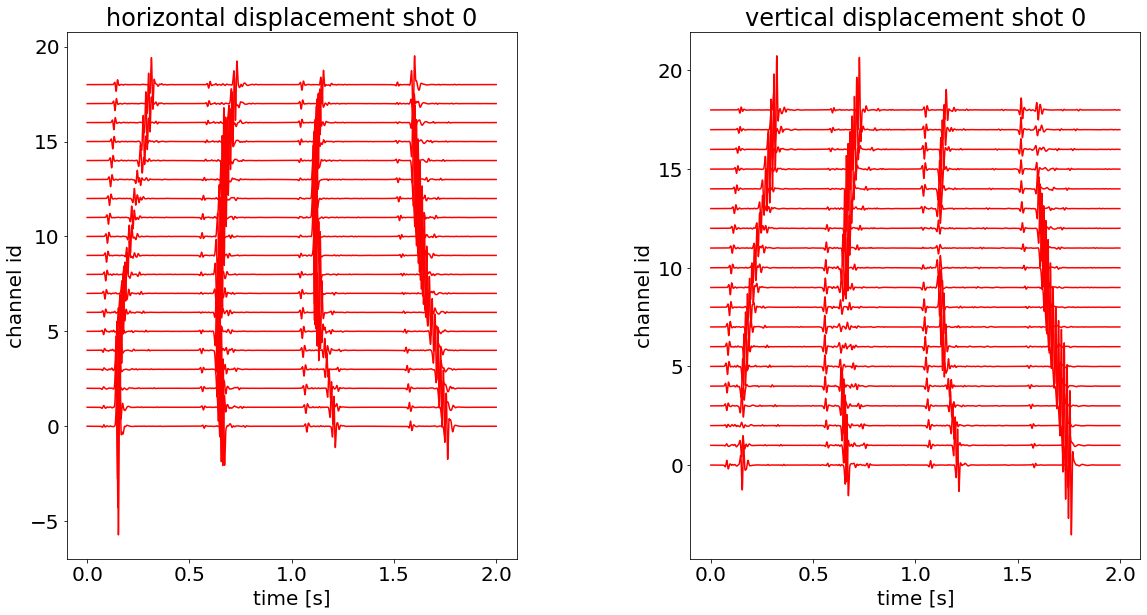

In [4]:
# Create true data ------------------------------------------------------------

for i_shot in range(model.n_shots):
    model.forward_simulate(i_shot, omp_threads_override=6)

# Cheating of course, as this is synthetically generated data.
ux_obs, uz_obs = model.get_synthetic_data()

model.set_observed_data(ux_obs, uz_obs)

model.plot_observed_data()

fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(18, 16)

In this simulation, we stagger 4 sources in time, such that their wavefields do not overlap (hopefully). We can see in the synthetic data that at least none of the wavefields are mixed at the receivers.

Now, let's have a look at how we compute the gradient of the misfit function w.r.t. the pixel grids. To do this, we need to do a few things:

1. Set some observed data (we did this in the previous cell)
2. Forward simulate all sources
3. Calculate the misfit
4. Calculate the adjoint sources
5. Empty the kernels (from any previous calculation)
6. Adjoint simulate all sources
7. Transform the sensitivity kernels (in Lamé's paramters) to velocity

Luckily, all these methods are fairly straightforward. Below is how one computes all these quantities by hand:

In [5]:
# Reverting the model to the starting model -----------------------------------

vp = vp_starting
vs = vs_starting
rho = rho_starting

model.set_parameter_fields(vp_starting, vs_starting, rho_starting)


for i_shot in range(model.n_shots):
    model.forward_simulate(i_shot, omp_threads_override=6)
model.calculate_l2_misfit()

print(f"Data misfit: {model.misfit:.2f}")

model.calculate_l2_adjoint_sources()
model.reset_kernels()
for i_shot in range(model.n_shots):
    model.adjoint_simulate(i_shot, omp_threads_override=6)
model.map_kernels_to_velocity()

Data misfit: 1920401.82


We have some data misfit. That doesn't tell us much. Let's have a look at the gradient themselves. We can either:

1. Obtain the gradient vector, containing all parameters
2. Obtain the gradient pixel fields, separated by parameter. 

The last one is much nicer for plotting:

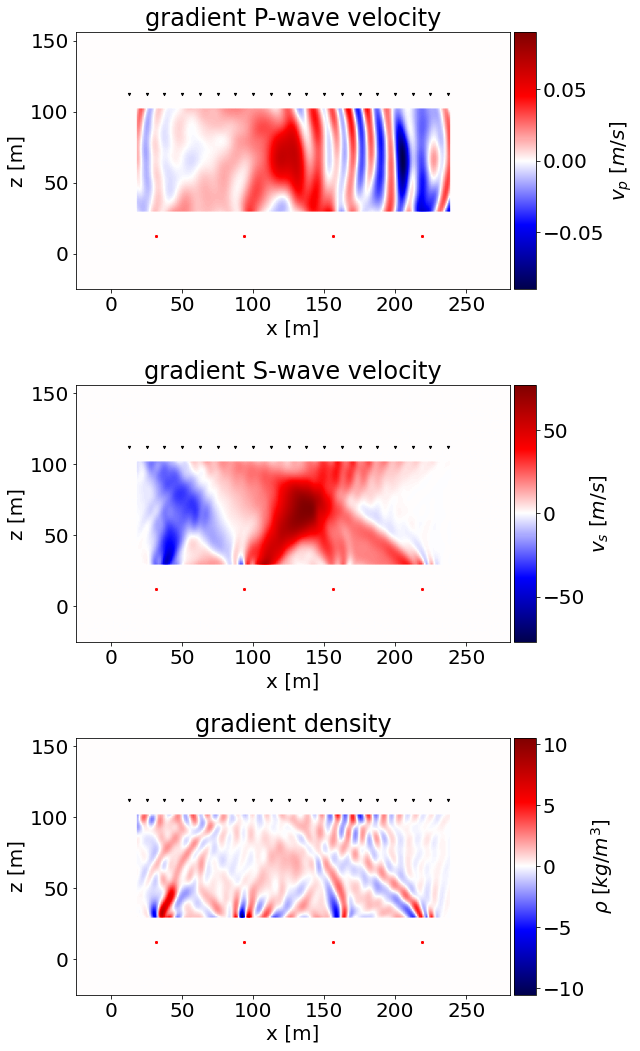

In [6]:
g_vp, g_vs, g_rho = model.get_kernels()

extrema = numpy.abs(g_vp).max(), numpy.abs(g_vs).max(), numpy.abs(g_rho).max()

extent = (extent[0], extent[1], extent[3], extent[2])

gradients = [g_vp, g_vs, g_rho]

plt.figure(figsize=(9, 15))
plt.tight_layout()
axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

[
    axis.set_title(f"gradient {parameter}")
    for axis, parameter in zip(axes, parameters)
]

extrema = numpy.array([numpy.abs(g).max() for g in gradients])
_ = model.plot_fields(gradients, vmin=-extrema, vmax=extrema, axes=axes)

Interestingly, the S-wave velocity gradients are much higher than the other two. Also the shapes differ strongly. We won't discuss this too much here, but this is typical behaviour when S-wave amplitudes are much higher. The shape of the gradients for density are mainly dominated by contrast, not by bulk value, hence their distinct patterns.

Now, to use these functions in a more practical way, we wrap everything up in a class. This class allows a direct interface with SciPy, thus giving access to their large array of optimization algorithms.

Note that we added functionality to smooth gradients before returning from the function.

In [7]:
class _fwi:

    last_model = numpy.empty_like(model.get_model_vector())
    misfit = None
    g = None
    smoothing = None

    def __init__(self):
        pass

    def misfit(self, m):

        if numpy.allclose(m, self.last_model):
            return self.misfit
        else:
            _ = self.grad(m)
            return self.misfit

    def grad(self, m):

        if numpy.allclose(m, self.last_model):
            return self.g
        else:
            model.set_model_vector(m)

            # Simulate forward
            for i_shot in range(model.n_shots):
                model.forward_simulate(i_shot, omp_threads_override=6)

            # Calculate misfit and adjoint sources
            model.calculate_l2_misfit()
            model.calculate_l2_adjoint_sources()
            self.misfit = model.misfit

            # Simulate adjoint
            model.reset_kernels()
            for i_shot in range(model.n_shots):
                model.adjoint_simulate(i_shot, omp_threads_override=6)
            model.map_kernels_to_velocity()

            g = model.get_gradient_vector()

            if self.smoothing is not None:
                g = numpy.hstack(
                    [
                        gaussian_filter(
                            igs.reshape((60, 180)), sigma=self.smoothing
                        ).flatten()
                        for igs in numpy.split(g, 3)
                    ]
                )

            self.g = g

            self.last_model = m

            return self.g

Let's run this inversion for 50 steps, without smoothing. We start at the homogeneous background model.

In [8]:
fwi = _fwi()
# fwi.smoothing = 4


model.set_parameter_fields(vp_starting, vs_starting, rho_starting)
m = model.get_model_vector()


res = minimize(
    fwi.misfit,
    m,
    method="L-BFGS-B",
    jac=fwi.grad,
    options={"gtol": 1e-6, "disp": True, "maxiter": 50, "maxcor": 10},
)

/opt/conda/envs/psvWave/lib/python3.9/site-packages/numpy/core/numeric.py:2369: RuntimeWarning: invalid value encountered in multiply
  y = y * ones_like(cond)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        32400     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92040D+06    |proj g|=  7.71590D+01

At iterate    1    f=  1.23699D+06    |proj g|=  6.88918D+01

At iterate    2    f=  8.23941D+05    |proj g|=  7.51454D+01

At iterate    3    f=  1.74338D+05    |proj g|=  1.74488D+01

At iterate    4    f=  1.17634D+05    |proj g|=  1.25240D+01

At iterate    5    f=  5.19360D+04    |proj g|=  6.01939D+00

At iterate    6    f=  3.39533D+04    |proj g|=  4.60625D+00

At iterate    7    f=  2.54042D+04    |proj g|=  4.59770D+00

At iterate    8    f=  1.84529D+04    |proj g|=  2.02678D+00

At iterate    9    f=  1.62482D+04    |proj g|=  1.90577D+00

At iterate   10    f=  1.25598D+04    |proj g|=  1.37480D+00

At iterate   11    f=  1.04079D+04    |proj g|=  2.10952D+00

At iterate   12    f=  9.70707D+03    |proj g|=  1.97650D+00

At iterate   13    f=  8.7

In [9]:
# This fails on most systems (out of memory), but one could inspect
# the Hessian for smaller models.
# hessian_inv = res.hess_inv.todense()

Plot the final model.

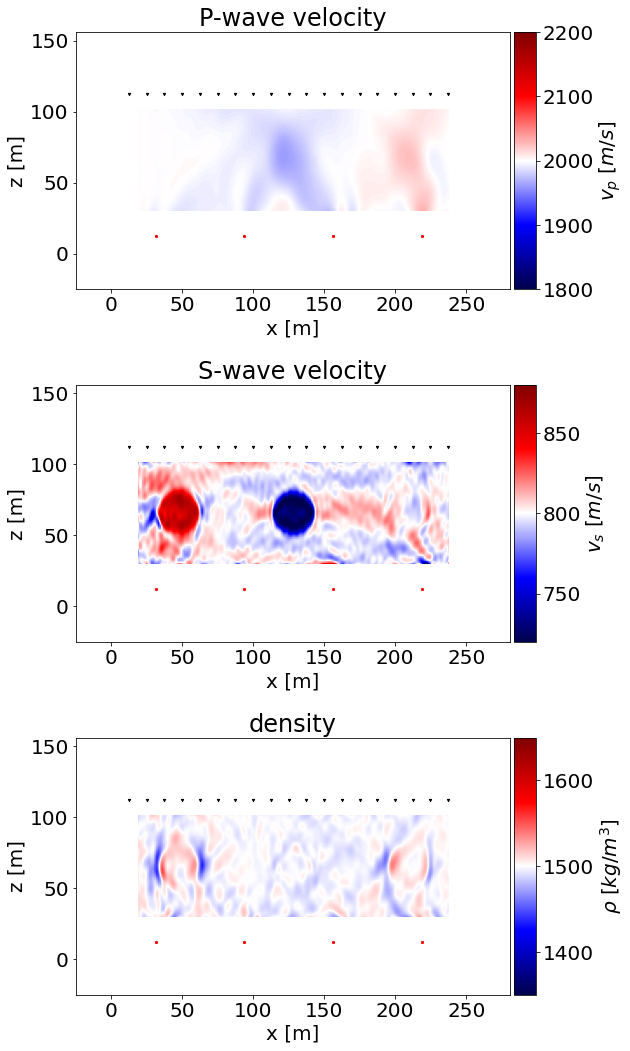

In [10]:
plt.figure(figsize=(9, 15))
plt.tight_layout()
axes = [plt.subplot(3, 1, i + 1) for i in range(3)]

parameters = ["P-wave velocity", "S-wave velocity", "density"]
[axis.set_title(f"{parameter}") for axis, parameter in zip(axes, parameters)]

_ = model.plot_model_vector(
    res.x,
    axes=axes,
    vmin=background_values * 0.9,
    vmax=background_values * 1.1,
)
plt.show()

It seems that S-wave velocity is very well resolved. For density, we mostly see the edges of the circles retrieved. P-wave velocity in general is very ill-recovered.